In [21]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import sys
import json
import wave
import time
import pyaudio
import librosa
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Audio
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalMaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split


In [22]:
SEED = 42
BATCH_SIZE = 64
SAMPLE_RATE = 16000
VALIDATION_SPLIT = 0.2

In [23]:
def load_data(json_path):
    with open(json_path, "r") as fp:
        data = json.load(fp)
    return data

train_data = load_data('train_mfccs.json')
test_data = load_data('test_mfccs.json')


In [24]:
# Convert lists to numpy arrays
X_train = np.array(train_data["mfcc"])
y_train = np.array(train_data["labels"])
X_test = np.array(test_data["mfcc"])
y_test = np.array(test_data["labels"])

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [25]:
def model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.GlobalMaxPooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(np.unique(y_train)), activation='softmax')
    ])

    return model



In [26]:
# Input shape
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [27]:
input_shape

(13, 13, 1)

In [28]:
model = model(input_shape)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,438 (447.02 KB)

 Trainable params: 114,438 (447.02 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:

# Compile model
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=50)


Epoch 1/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3623 - loss: 1.6321 - val_accuracy: 0.5111 - val_loss: 1.2444
Epoch 2/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5286 - loss: 1.2281 - val_accuracy: 0.5815 - val_loss: 1.1236
Epoch 3/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5834 - loss: 1.1027 - val_accuracy: 0.6253 - val_loss: 1.0169
Epoch 4/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6193 - loss: 1.0136 - val_accuracy: 0.6276 - val_loss: 0.9884
Epoch 5/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6395 - loss: 0.9432 - val_accuracy: 0.6436 - val_loss: 0.9744
Epoch 6/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6616 - loss: 0.8953 - val_accuracy: 0.6584 - val_loss: 0.9149
Epoch 7/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6683 - loss: 0.8614 - val_accuracy: 0.6573 - val_loss: 0.9169
Epoch 8/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6878 - loss: 0.8214 - val_accuracy: 0.

In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.2f}')

  8/164 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4866 - loss: 3.6588  

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6218 - loss: 2.3178
Test Accuracy: 0.60


In [31]:
# Assuming you have the test data prepared as X_test and y_test
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Calculate accuracy, precision, and F1 score
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print classification report
class_report = classification_report(y_test, y_pred_classes)
print("Classification Report:\n", class_report)



164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.53      0.55       983
           1       0.69      0.95      0.80       608
           2       0.64      0.66      0.65       961
           3       0.66      0.55      0.60       942
           4       0.52      0.48      0.50       857
           5       0.53      0.53      0.53       885

    accuracy                           0.60      5236
   macro avg       0.60      0.62      0.60      5236
weighted avg       0.60      0.60      0.59      5236



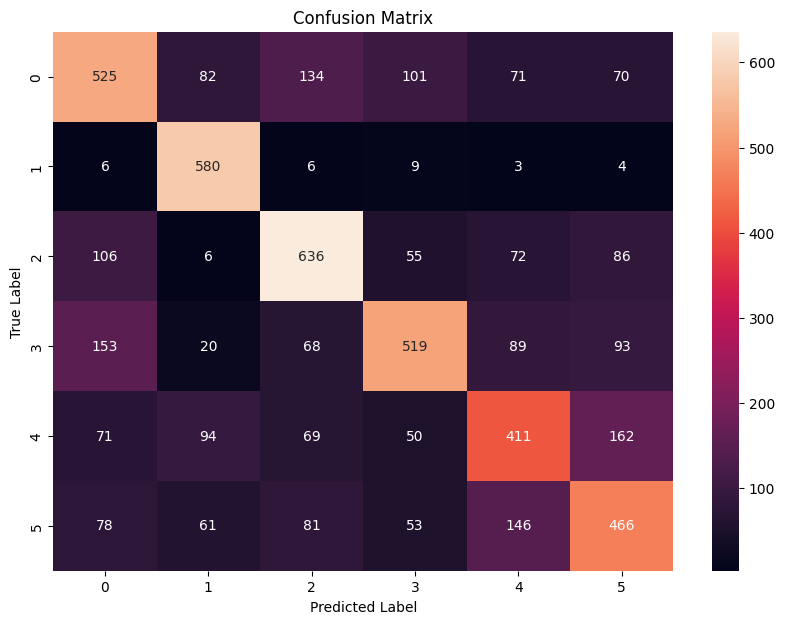

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, classification_report


# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)



# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


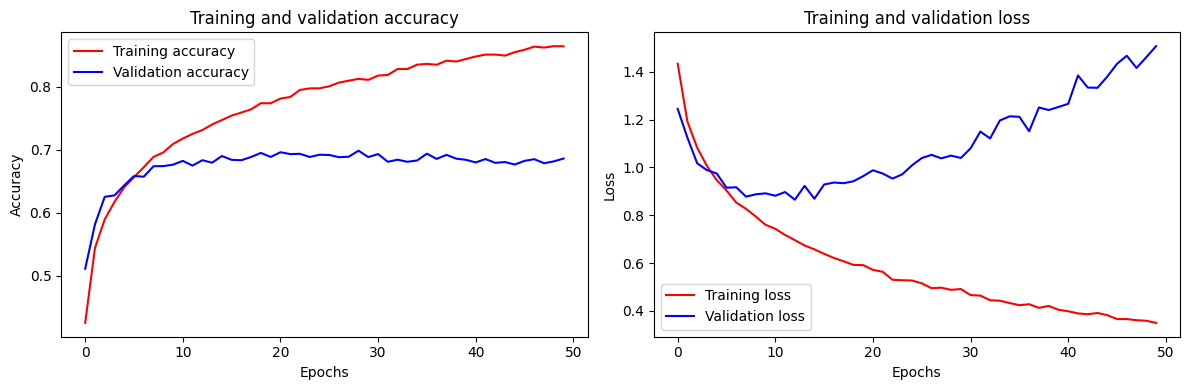

In [33]:

# Function to plot the training history
def plot_training_history(history):
    try:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(acc))

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'r', label='Training accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"An error occurred during plotting the training history: {str(e)}")
        
plot_training_history(history)


In [34]:
model.save("audio_classification_model.h5")

In [35]:
def predict(file_path, model):
    # Load the audio file
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T

    # Ensure the correct shape
    mfcc = np.expand_dims(mfcc, axis=-1)
    mfcc = np.expand_dims(mfcc, axis=0)

    # Make prediction
    prediction = model.predict(mfcc)
    predicted_index = np.argmax(prediction, axis=1)
    return predicted_index

# Load the model
model = tf.keras.models.load_model('audio_classification_model.h5')



In [36]:
train_data_dir = pathlib.Path('Dataset/Train')

emabega_file_path = os.path.join(train_data_dir, 'emabega', 'emabega_001.wav')
ddyo_file_path = os.path.join(train_data_dir, 'ddyo', 'ddyo_001.wav')

In [37]:
#  Predict
file_path = ddyo_file_path
predicted_class = predict(file_path, model)
print(f'Predicted Class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Predicted Class: [4]


In [38]:
KERAS_MODEL_PATH = "model/mfcc_model_1.keras"
model.save(KERAS_MODEL_PATH)


In [39]:
# Function to get the file size
def get_and_convert_file_size(file_path, unit=None):
    size = os.path.getsize(file_path)
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [40]:
keras_model_size = get_and_convert_file_size(KERAS_MODEL_PATH, 'KB')

File size: 483.708 Kilobytes
